In [3]:
import math
import os
import copy
import time
import warnings
import torch

from tempfile import TemporaryDirectory
from typing import Tuple
from typing import List
from typing import Optional, Tuple
from typing import Optional, Any, Union, Callable

from torch import nn, Tensor
from torch.nn import functional as F
from torch.utils.data import dataset
from transformers import PreTrainedModel
from torch.nn.modules.linear import NonDynamicallyQuantizableLinear
from torch.nn.init import constant_, xavier_normal_, xavier_uniform_
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.nn.modules.container import ModuleList
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.linear import Linear
from torch.nn.modules.normalization import LayerNorm

from transformers import PretrainedConfig
from transformers import OpenAIGPTConfig, AutoTokenizer, OpenAIGPTLMHeadModel 

import matplotlib.pyplot as plt

/home/yuandong/miniconda3/envs/fooocus/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import random

complex_type = torch.cdouble
real_type = torch.double

d = 37
# Fourier bases

v = torch.ones(d, dtype=complex_type)
# unit 
for i in range(d):
    v[i].real = math.cos(2 * math.pi * i / d)
    v[i].imag = math.sin(2 * math.pi * i / d)
    
U = torch.zeros(d, d, dtype=complex_type, requires_grad=False)
for i in range(d):
    U[:,i] = v ** i / math.sqrt(d)
    
U = U.conj()

In [5]:
import math

def dsqr(x):
    return x

def dselu(v):
    return torch.sigmoid(v) * (1 + v * (1 - torch.sigmoid(v)))

def drelu(v):
    return (v > 0).float()

def show_signal(x):
    plt.subplot(1, 3, 1)
    plt.plot(x)
    
    f = U.t().conj() @ x
    
    plt.subplot(1, 3, 2)
    plt.plot(range(0, x.shape[0]), f.abs() )
    
    plt.subplot(1, 3, 3)
    plt.plot(range(0, x.shape[0]), f.angle() )
    
    # Find the highest frequency and the corresponding angles.
    d = x.shape[0]
    index = f.abs().argmax().item()
    dual_index = d - index
    index = min(index, dual_index)
    
    plt.axvline(x.shape[0] / 2, linestyle='--', color='r')
    
    return index, f.angle()[index].item()
    

In [6]:
# multiplication table
mul_table = torch.zeros(d, d, dtype=torch.int)

for i in range(d):
    for j in range(d):
        mul_table[i, j] = (i + j) % d
        
#probs = torch.ones(d, d)
# probs = torch.rand(d, d) * 0.2 + 1

# probs = torch.ones(d)
probs1 = torch.rand(d) * 2 + 1
probs1 = probs1 / probs1.sum()

# probs2 = probs1

probs2 = torch.rand(d) * 2 + 1
probs2 = probs2 / probs2.sum()

In [12]:
# Rho representation
class Density:
    def __init__(self, d, r, ratio_sample=0.5):
        # The density rho(g_1, g_2) = \sum_{k=1}^r p_{k1}(g_1)p_{k2}(g_2)
        use_svd = True        
        
        if use_svd:
            # We can start with a joint distribution and then decompose
            rhos = (torch.rand(d, d) > ratio_sample).float()
            # rhos = torch.ones(d, d)
            rhos = rhos / rhos.sum()

            # Do SVD
            U_, D_, V_ = torch.svd(rhos, compute_uv=True)
            self.p1s = U_[:,:r] * D_[None,:r].sqrt()
            self.p2s = V_[:,:r] * D_[None,:r].sqrt()
            
        else:
            self.p1s = (torch.rand(d, r, dtype=real_type) > 0.7).float()
            self.p2s = (torch.rand(d, r, dtype=real_type) > 0.7).float()
            self.p1s = self.p1s / self.p1s.sum(dim=0, keepdim=True) / math.sqrt(r)
            self.p2s = self.p2s / self.p2s.sum(dim=0, keepdim=True) / math.sqrt(r)

        self.r = r
        self.d = d
        
        self.b1_fs = torch.zeros(d, self.r, dtype=complex_type)
        self.a2_fs = torch.zeros(d, self.r, dtype=complex_type)
        
        for rr in range(self.r):
            probs1 = self.p1s[:,rr]
            probs2 = self.p2s[:,rr]
            self.b1_fs[:,rr] = U.t().conj() @ probs2.to(complex_type)
            self.a2_fs[:,rr] = U.t().conj() @ probs1.to(complex_type)

        
    def get_rho(self):
        # Get the joint probability
        return self.p1s @ self.p2s.t()
    
    def visualize_pred(self, U, w, v):
        w_c = w.to(complex_type)
        v_c = v.to(complex_type)
        
        # Just estimate delta_w1
        est_delta_wa_f = torch.zeros(d, dtype=complex_type)
        est_delta_wb_f = torch.zeros(d, dtype=complex_type)
        est_delta_v_f = torch.zeros(d, dtype=complex_type)
        
        for rr in range(self.r):
            probs1 = self.p1s[:,rr]
            probs2 = self.p2s[:,rr]
            
            b1_f = self.b1_fs[:,rr]
            a2_f = self.a2_fs[:,rr]
            
            # Analytic form
            a1 = (w_c[:self.d] * probs1).to(complex_type)
            b2 = (w_c[self.d:] * probs2).to(complex_type)

            wa_f = U.t().conj() @ w_c[:self.d]
            wb_f = U.t().conj() @ w_c[self.d:]

            a1_f = U.t().conj() @ a1
            b2_f = U.t().conj() @ b2
            v_f = U.t().conj() @ v_c

            for i in range(d):
                j_range = range(1, d)
                indices = [ (i - j + d) % d for j in j_range ]
                p1a = (a1_f[indices] * b1_f[j_range].conj() * v_f[j_range]).sum()
                p2a = (a2_f[indices] * b2_f[j_range].conj() * v_f[j_range]).sum()

                # Swap a and b
                p1b = (b1_f[indices] * a1_f[j_range].conj() * v_f[j_range]).sum()
                p2b = (b2_f[indices] * a2_f[j_range].conj() * v_f[j_range]).sum()

                est_delta_wa_f[i] += p1a + p2a
                est_delta_wb_f[i] += p1b + p2b

                if i > 0:
                    j_range = range(d)
                    indices = [ (i - j + d) % d for j in j_range ]
                    p1v = (a1_f[indices].conj() * wa_f[j_range].conj()).sum() * b1_f[i] + (b1_f[indices].conj() * wb_f[j_range].conj()).sum() * a1_f[i]
                    p2v = (a2_f[indices].conj() * wa_f[j_range].conj()).sum() * b2_f[i] + (b2_f[indices].conj() * wb_f[j_range].conj()).sum() * a2_f[i]
                    est_delta_v_f[i] += p1v + p2v

#             plt.figure()
#             plt.plot(range(1,d), a1_f[1:].abs(), label=f'a1_f @ rank {rr} / {self.r}')
#             plt.plot(range(1,d), b2_f[1:].abs(), label=f'b2_f @ rank {rr} / {self.r}')
#             plt.plot(range(1,d), b1_f[1:].abs(), label=f'b1_f @ rank {rr} / {self.r}')
#             plt.plot(range(1,d), a2_f[1:].abs(), label=f'a2_f @ rank {rr} / {self.r}')
#             plt.legend()
#             plt.show()

        # est_delta_v_f doesn't need to be scaled
        return est_delta_wa_f * 2, est_delta_wb_f * 2, est_delta_v_f

In [8]:
N1 = mul_table.shape[0] 
N2 = mul_table.shape[1] 
N3 = mul_table.max() + 1

N = N1 * N2

F1 = torch.zeros(N1, N2, N1, dtype=real_type)
F2 = torch.zeros(N1, N2, N2, dtype=real_type)
G = torch.zeros(N1, N2, N3, dtype=real_type)

for i in range(N1):
    for j in range(N2):        
        F1[i, j, i] = 1
        F2[i, j, j] = 1
        G[i, j, mul_table[i, j]] = 1

F1 = F1.view(-1, N1)
F2 = F2.view(-1, N2)
F = torch.cat([F1, F2], dim=1)
# F = F - F.mean(dim=0, keepdim=True)

G = G.view(-1, N3)
G = G - G.mean(dim=0, keepdim=True)

In [13]:
density = Density(d, 3, ratio_sample=0.6)
rhos = density.get_rho().view(-1)

In [10]:
w0 = torch.randn(N1+N2, dtype=real_type) * 0.01
v0 = torch.randn(N3, dtype=real_type) * 0.01

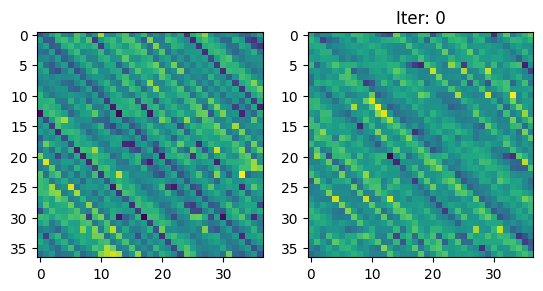

/home/yuandong/miniconda3/envs/fooocus/lib/python3.10/site-packages/torch/_tensor.py:1032: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


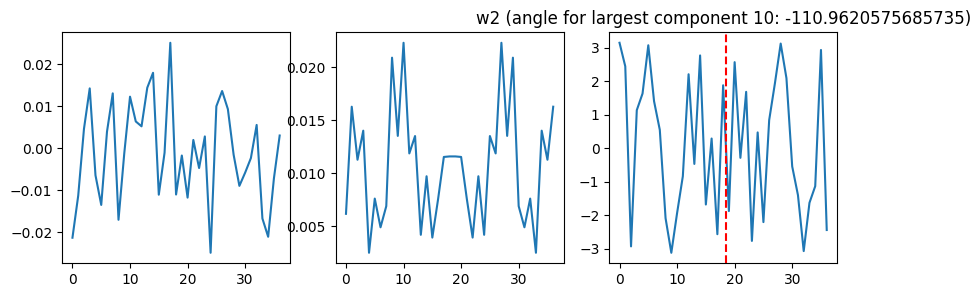

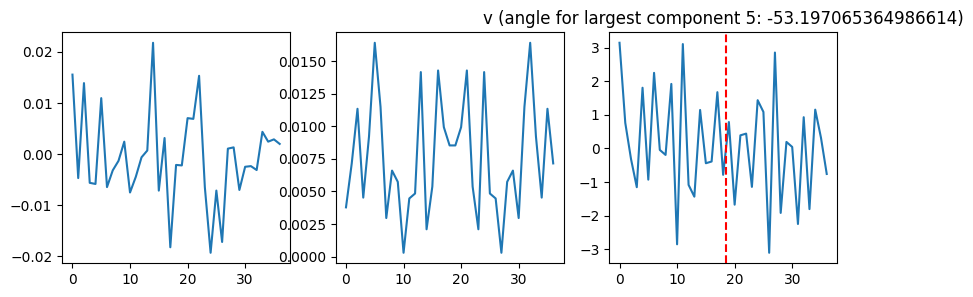

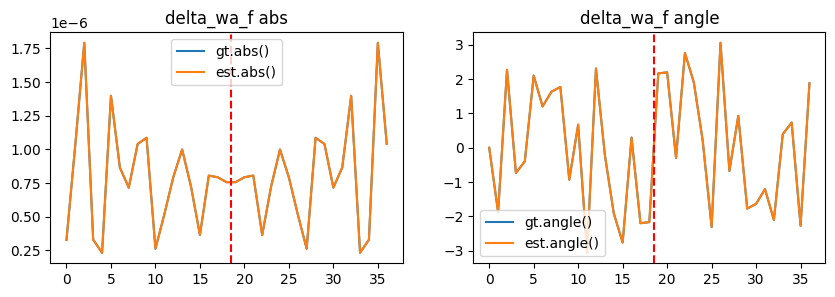

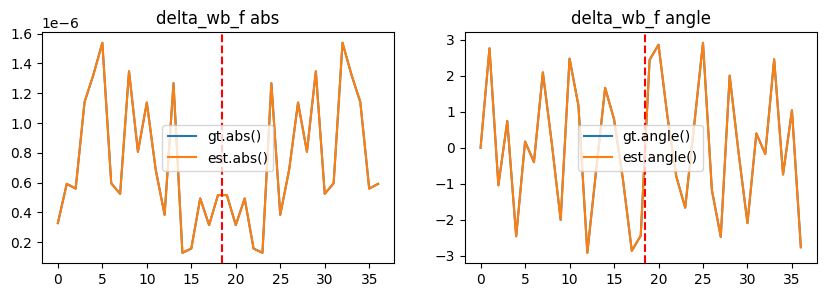

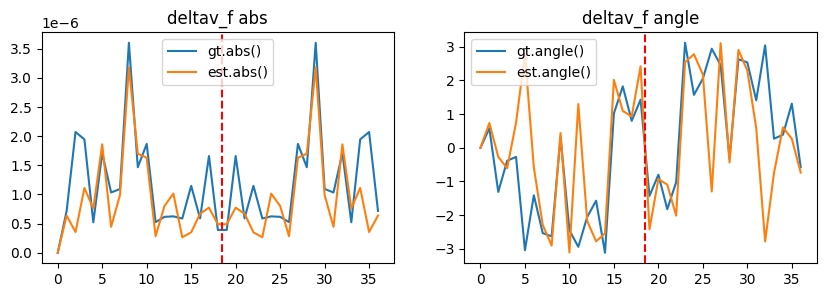

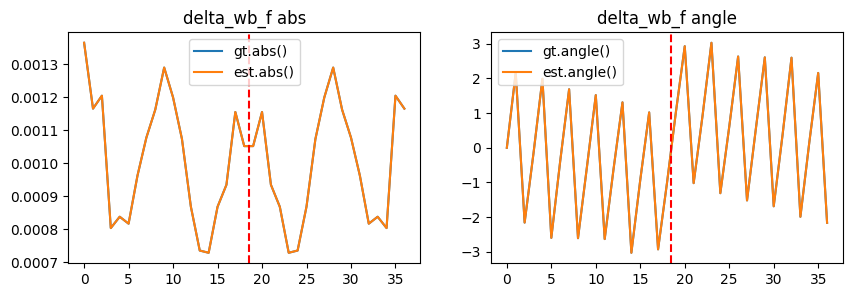

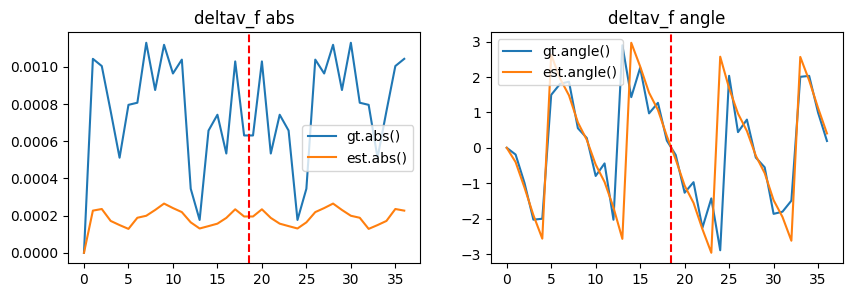

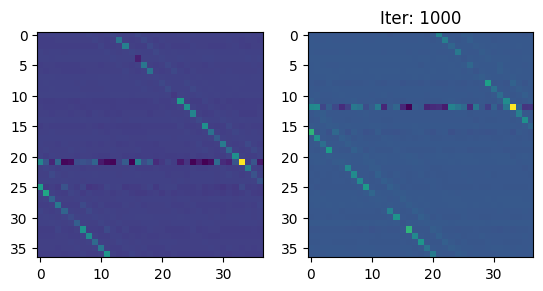

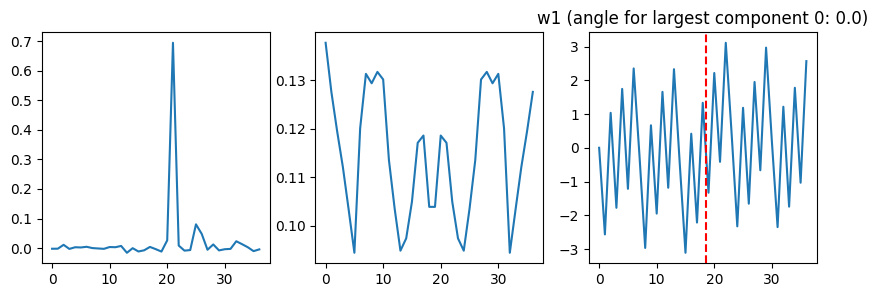

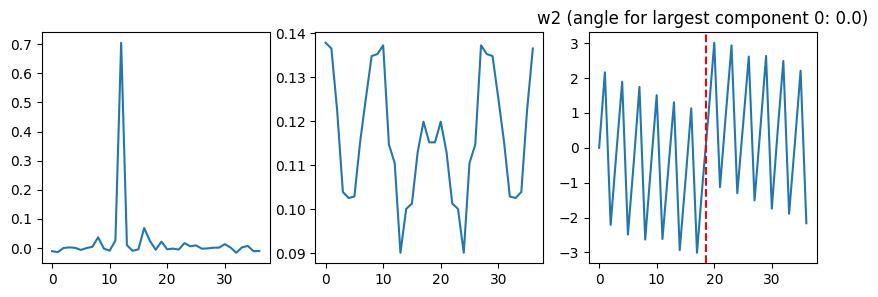

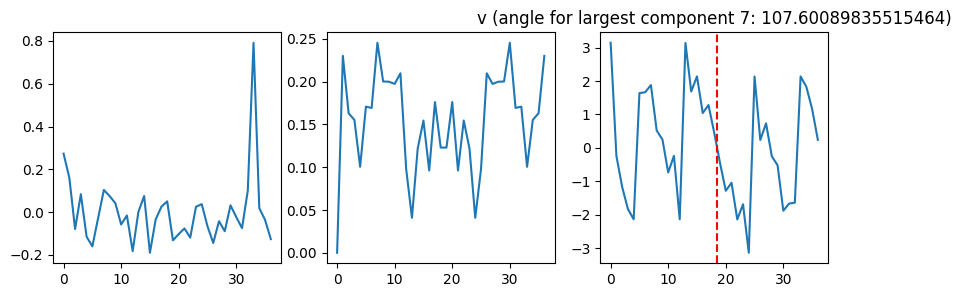

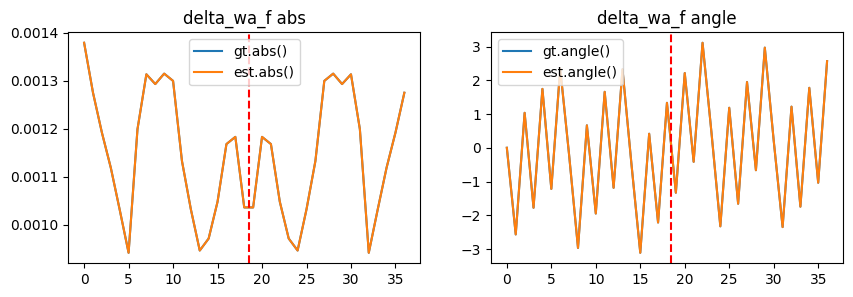

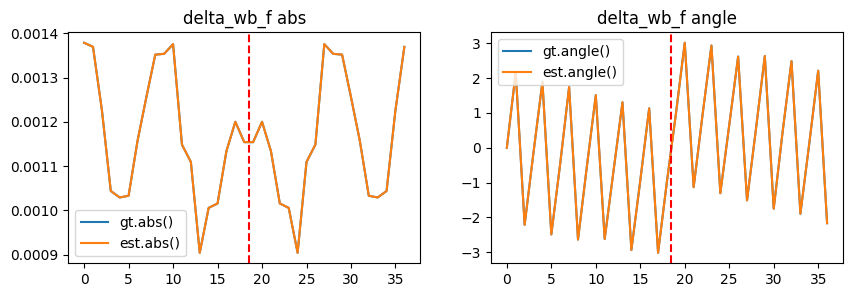

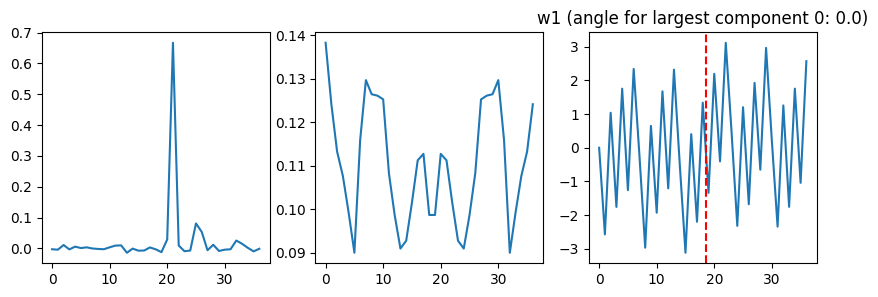

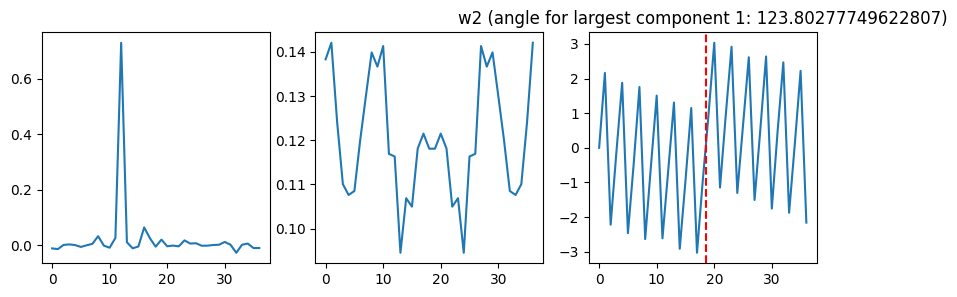

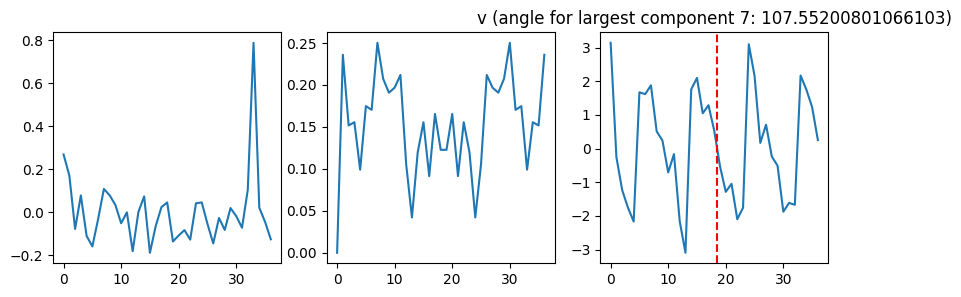

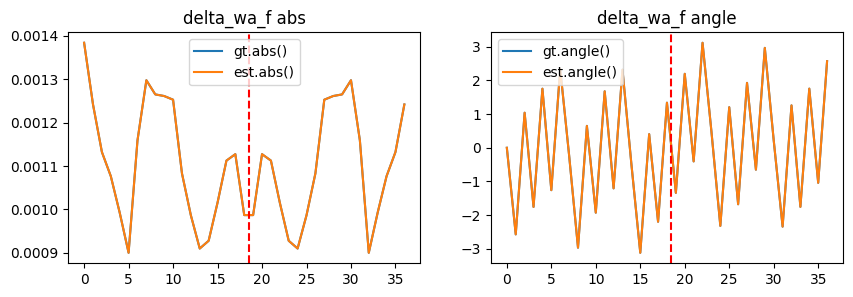

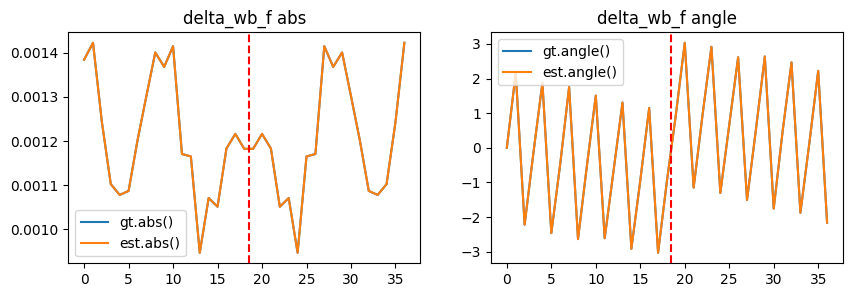

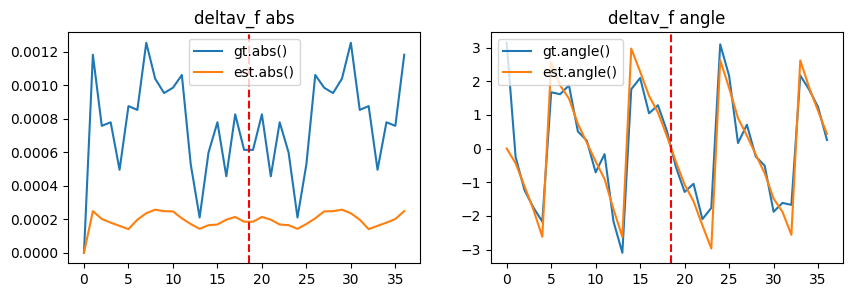

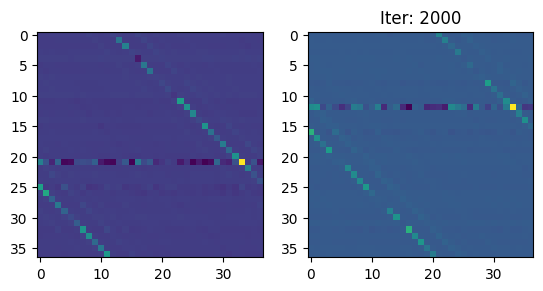

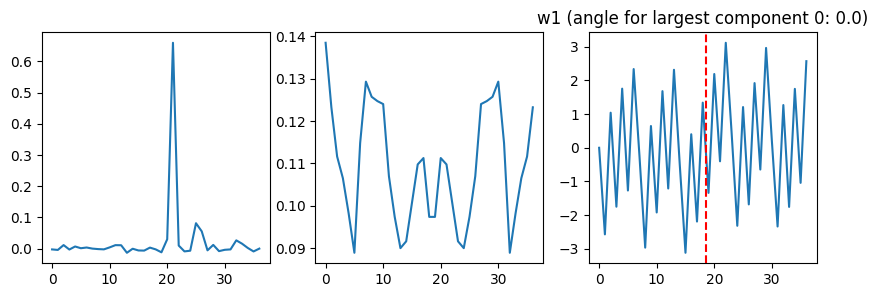

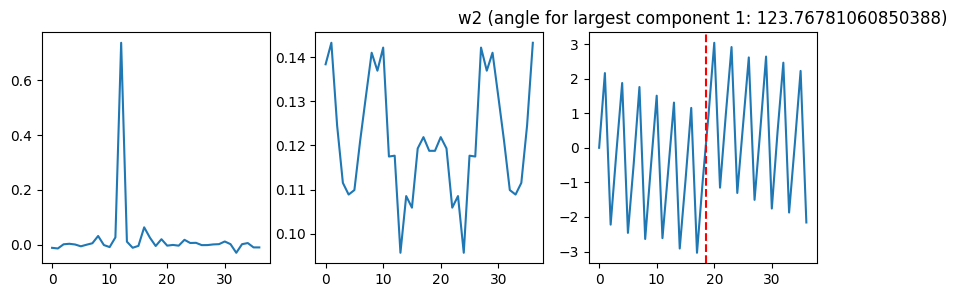

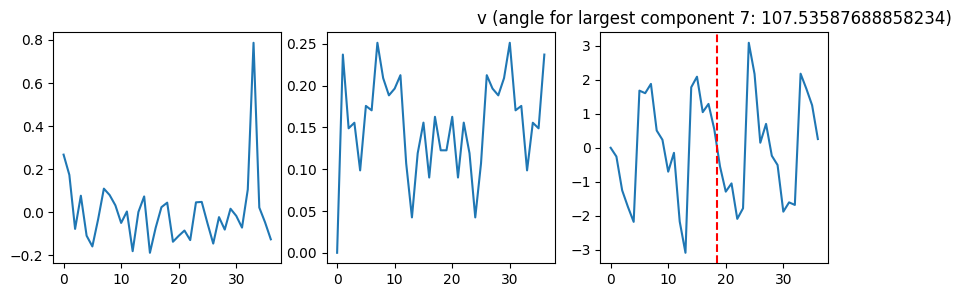

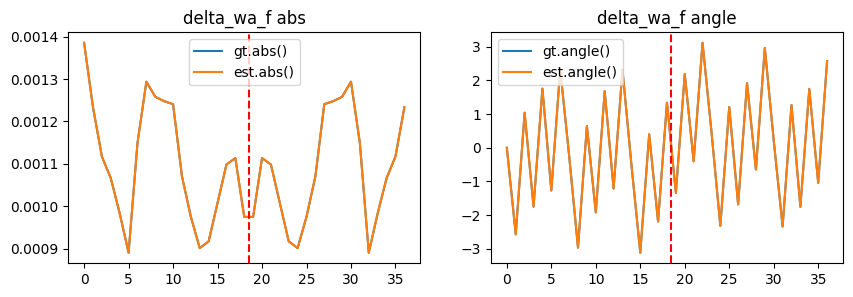

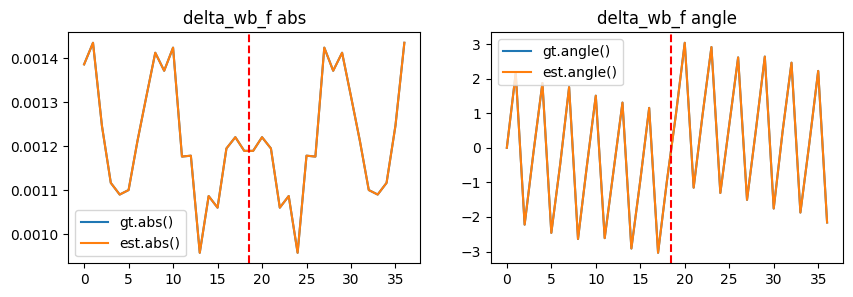

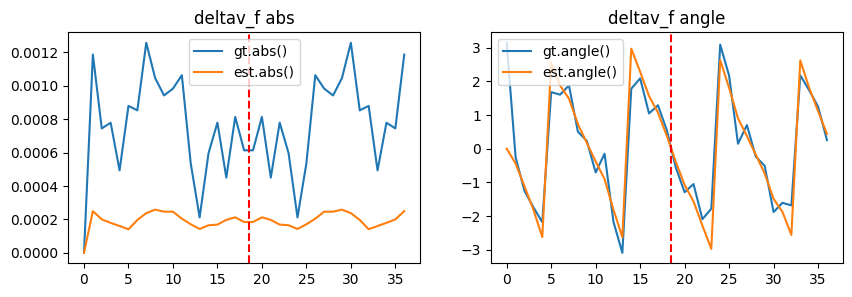

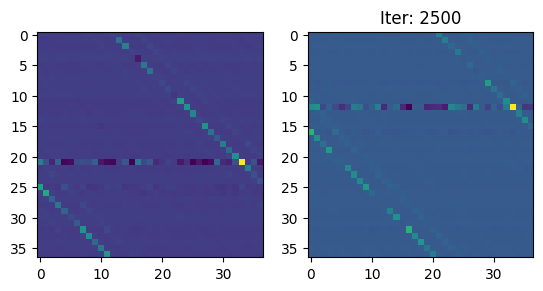

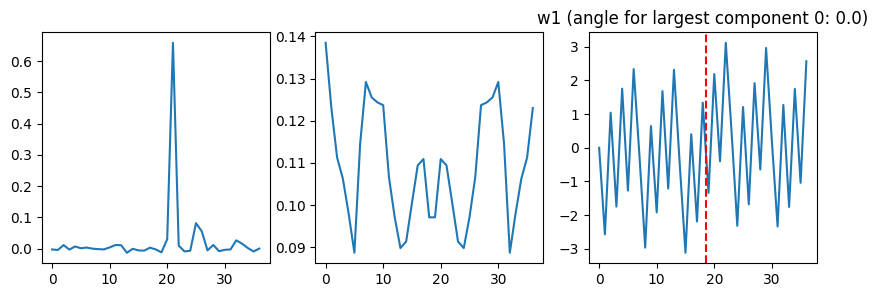

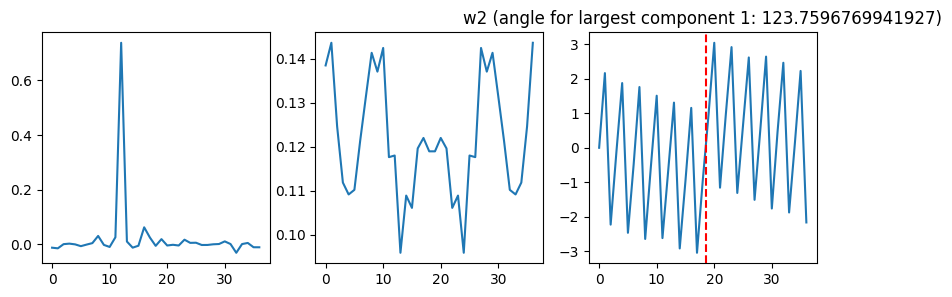

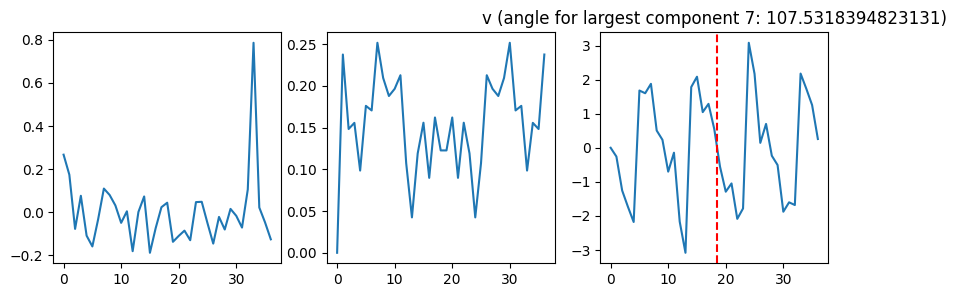

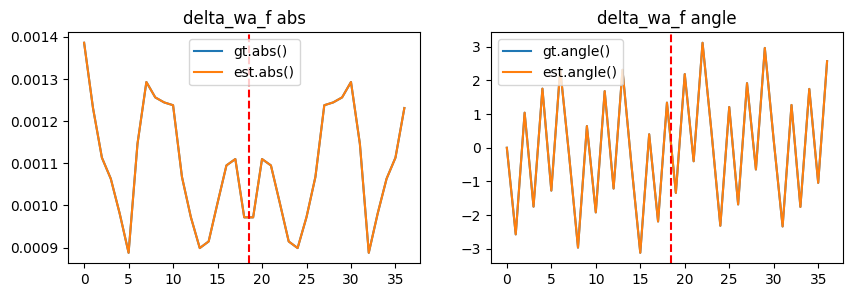

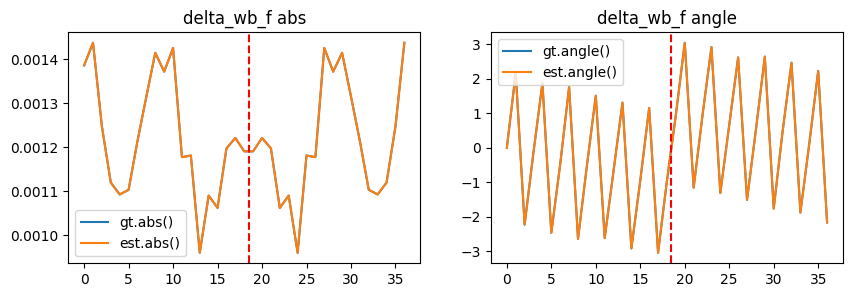

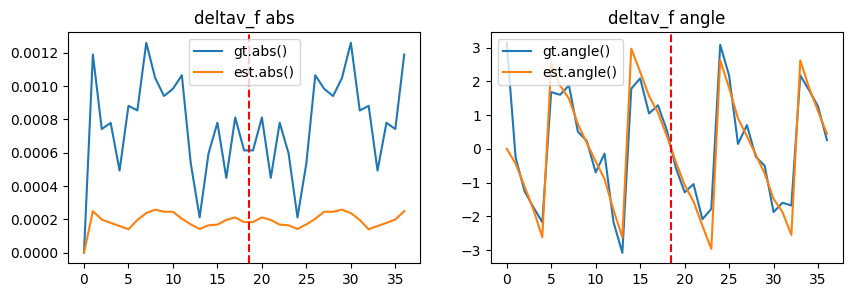

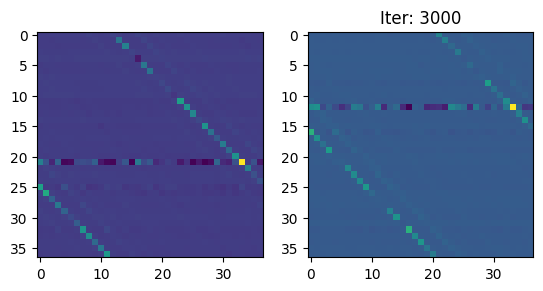

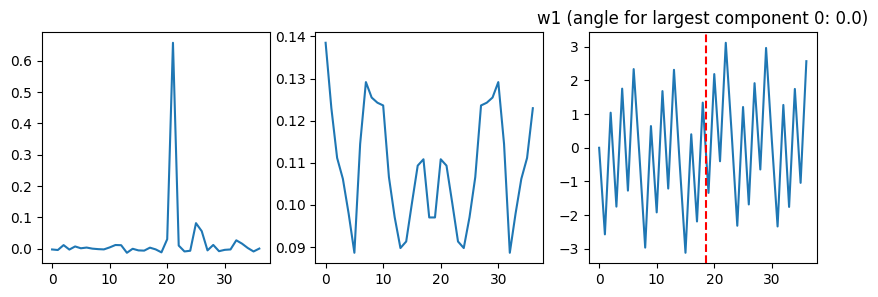

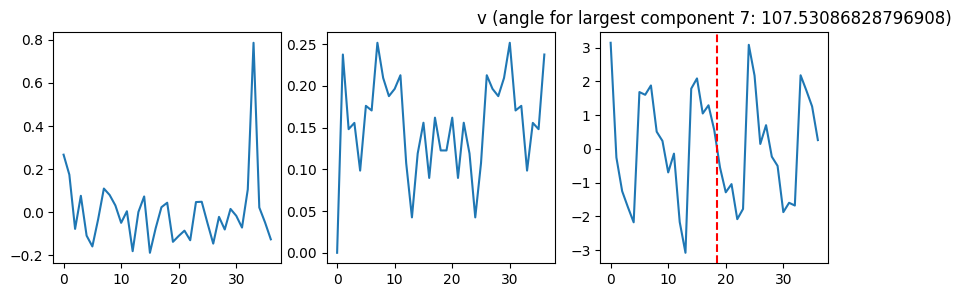

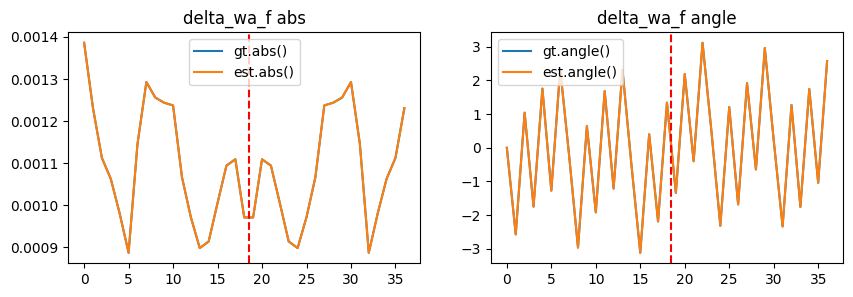

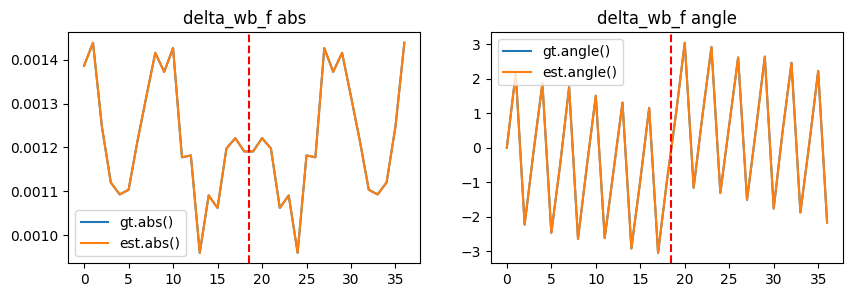

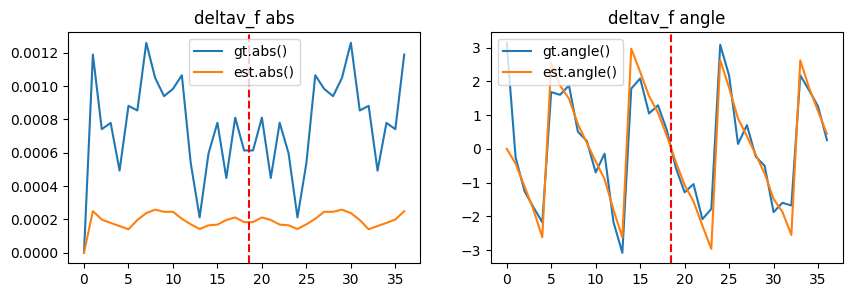

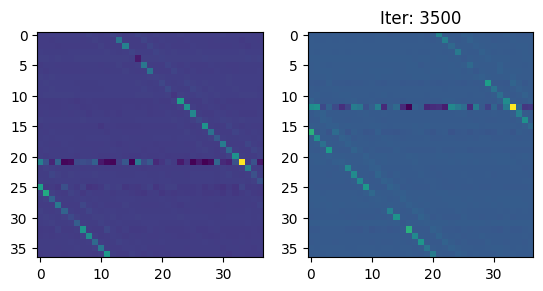

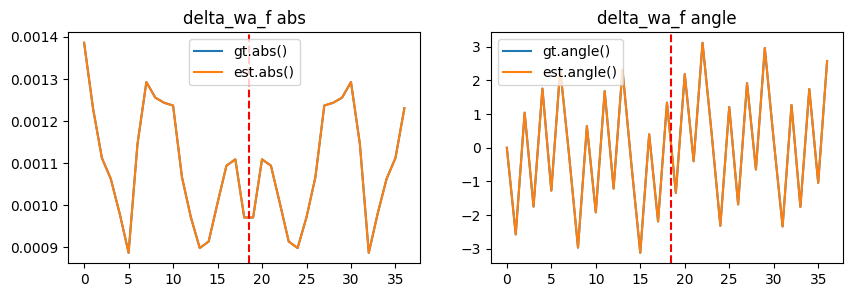

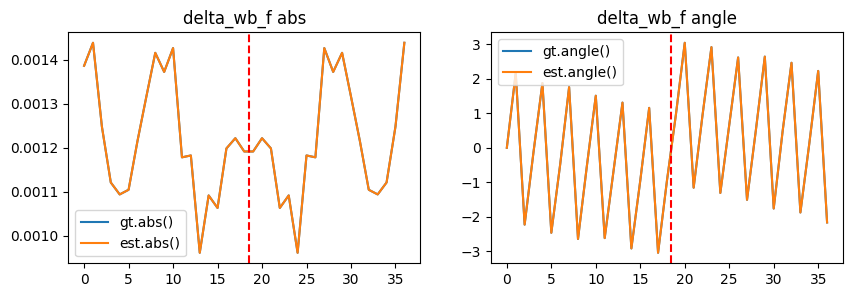

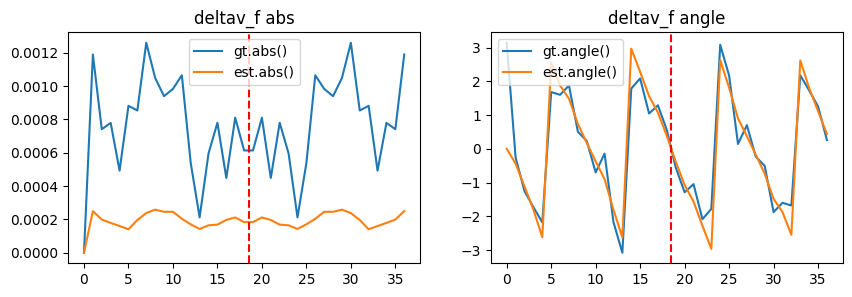

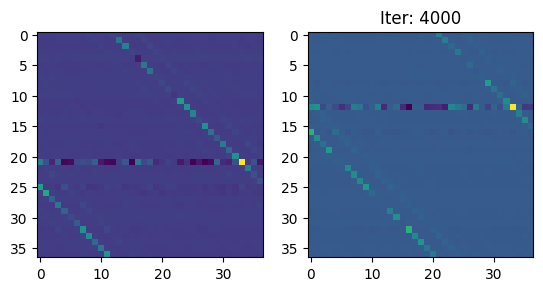

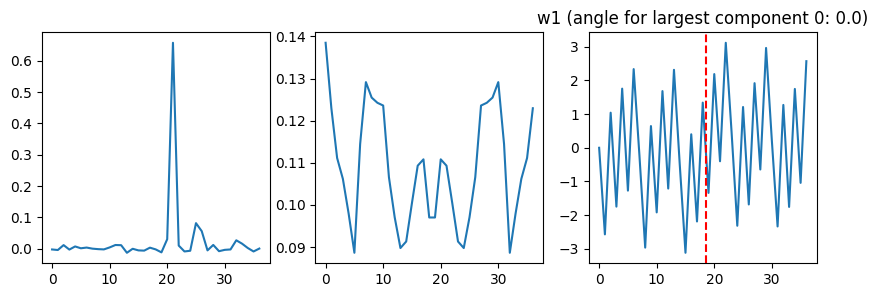

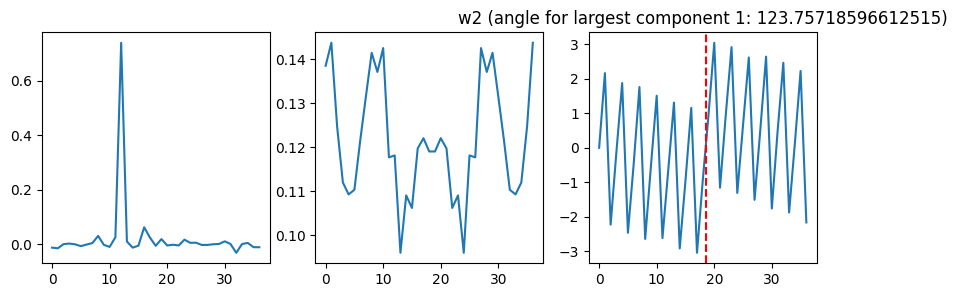

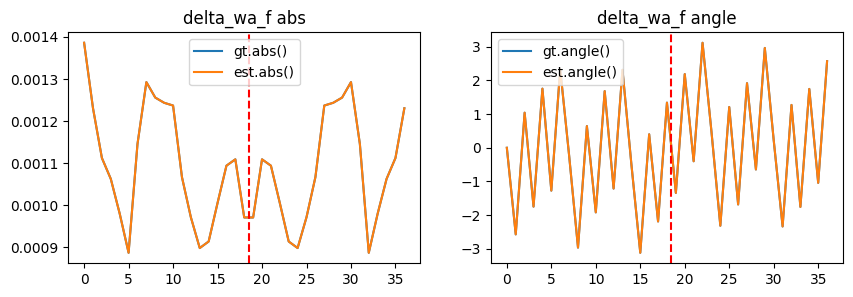

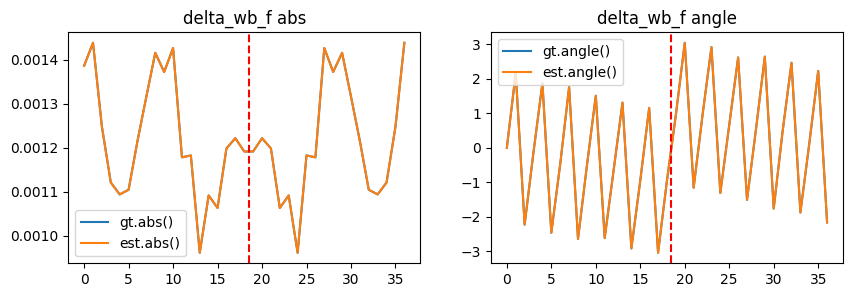

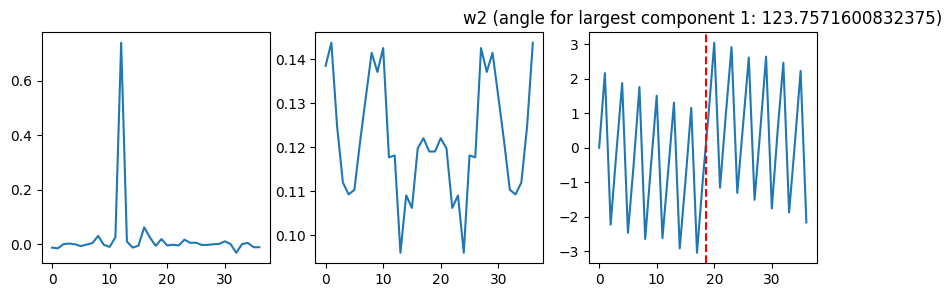

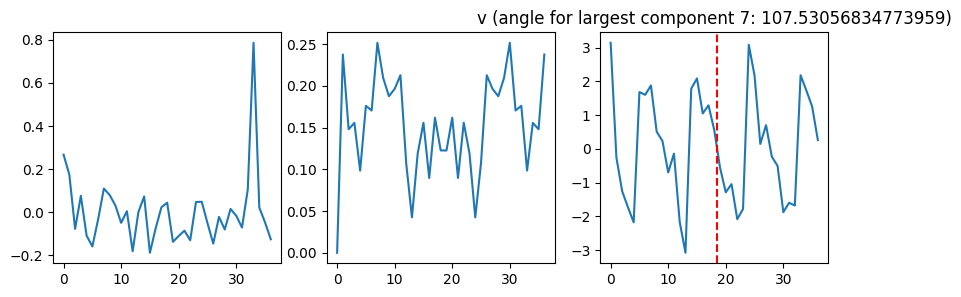

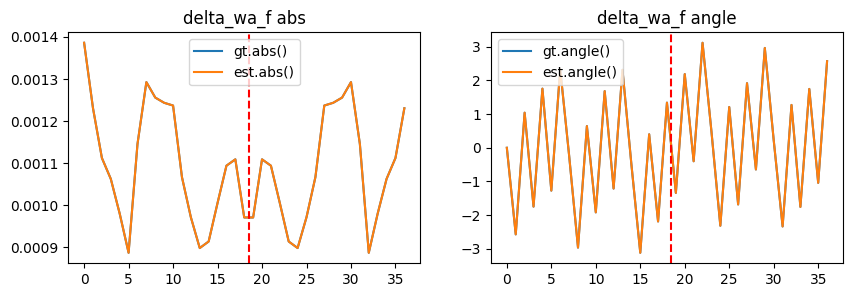

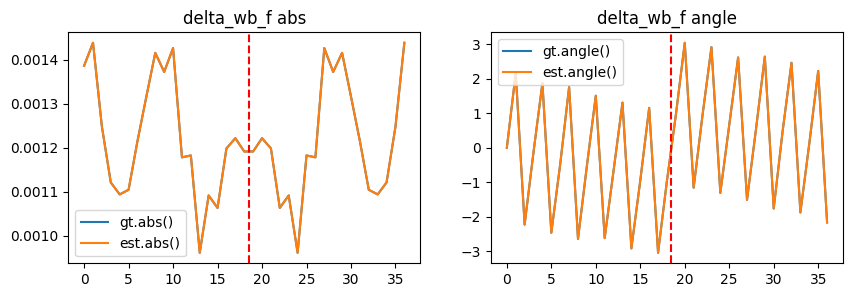

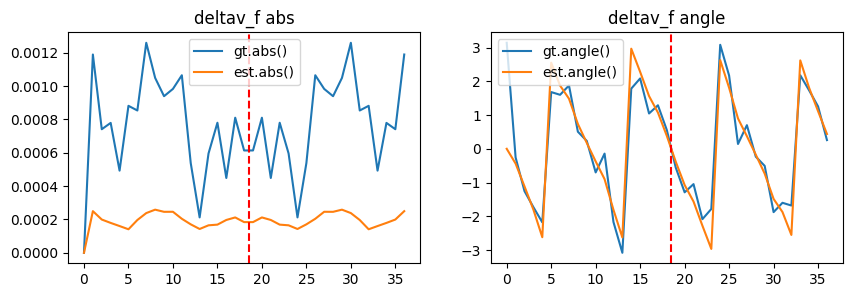

In [14]:
def compare_signal(gt, est, title=""):
    d = gt.shape[0]

    plt.figure(figsize=(10,3))

    plt.subplot(1, 2, 1)
    plt.plot(range(d), gt.abs(), label='gt.abs()')
    plt.plot(range(d), est.abs(), label='est.abs()')
    plt.axvline(d / 2, linestyle='--', color='r')
    plt.legend()
    plt.title(title + " abs")

    plt.subplot(1, 2, 2)
    plt.plot(range(d), gt.angle(), label='gt.angle()')
    plt.plot(range(d), est.angle(), label='est.angle()')
    plt.axvline(d / 2, linestyle='--', color='r')
    plt.legend()
    plt.title(title + " angle")

    plt.show()

w = w0[:]
v = v0[:]

alpha = 5
eta = 0.1
nIter = 5000

wt = torch.zeros(N1+N2, nIter, dtype=real_type)
vt = torch.zeros(N3, nIter, dtype=real_type)

for t in range(nIter):    
    act_prime_rho = dsqr(F @ w) * rhos
    # act_prime_rho = dselu(F @ w) * rhos
    # B is (n1+n2)-by-n3
    B = (F.t() * act_prime_rho[None,:]) @ G
    
    if t % 500 == 0:
        plt.subplot(1, 2, 1)
        plt.imshow(B[:N1,:])
        plt.subplot(1, 2, 2)
        plt.imshow(B[N1:,:])
        plt.title(f"Iter: {t}")
        plt.show()
        
        w_c = w.to(complex_type)
        v_c = v.to(complex_type)
        
        plt.figure(figsize=(10,3))        
        idx, angle = show_signal(w_c[:N1])
        angle_degree = angle / math.pi * 180
        plt.title(f"w1 (angle for largest component {idx}: {angle_degree})")

        plt.figure(figsize=(10,3))        
        idx, angle = show_signal(w_c[N1:])
        angle_degree = angle / math.pi * 180
        plt.title(f"w2 (angle for largest component {idx}: {angle_degree})")

        plt.figure(figsize=(10,3))        
        idx, angle = show_signal(v_c)
        angle_degree = angle / math.pi * 180
        plt.title(f"v (angle for largest component {idx}: {angle_degree})")

        plt.show()
        
    #
    deltaw = 2 * B @ v
    deltav = B.t() @ w
    
    if t % 500 == 0:    
        # Compute convolution between w_1 and rho_1
        est_delta_wa_f, est_delta_wb_f, est_delta_v_f = density.visualize_pred(U, w, v)

        # Check whether est_delta_w is aligned with delta_w
        delta_wa_f = U.t().conj() @ deltaw[:N1].to(complex_type)
        delta_wb_f = U.t().conj() @ deltaw[N1:].to(complex_type)
        deltav_f = U.t().conj() @ deltav.to(complex_type)

        compare_signal(delta_wa_f, est_delta_wa_f, "delta_wa_f")
        compare_signal(delta_wb_f, est_delta_wb_f, "delta_wb_f")
        compare_signal(deltav_f, est_delta_v_f, "deltav_f")
        
    w = w + deltaw * alpha - eta * w
    v = v + deltav * alpha - eta * v
    
    # w = w - w.mean()
    # v = v - v.mean()
    
    w = w / w.norm()
    v = v / v.norm()
    
    wt[:,t] = w
    vt[:,t] = v

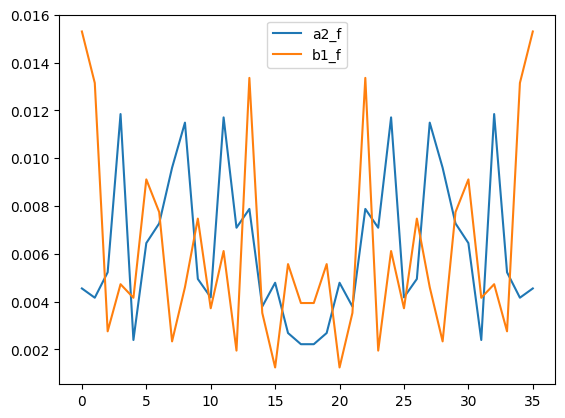

In [12]:
plt.plot(a2_f.abs()[1:], label="a2_f")
plt.plot(b1_f.abs()[1:], label="b1_f")
plt.legend()

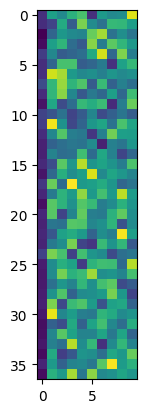

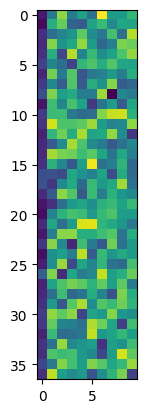

In [111]:
plt.imshow(density.p1s)
plt.show()

plt.imshow(density.p2s)
plt.show()

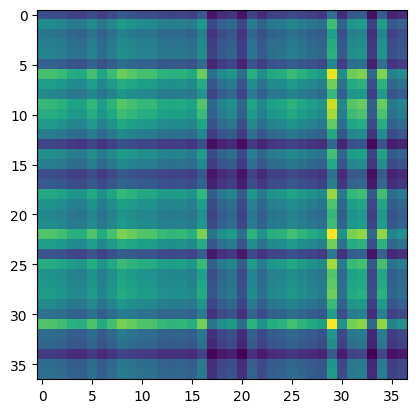

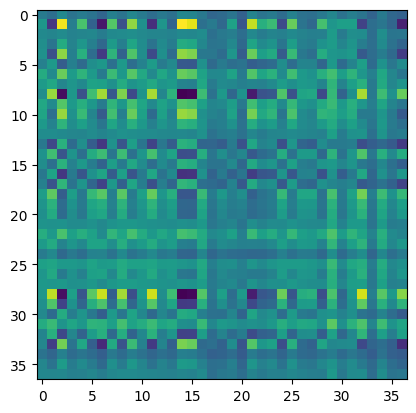

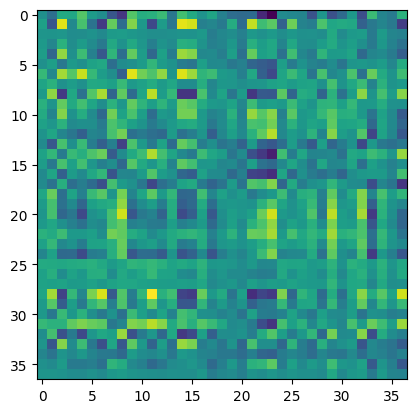

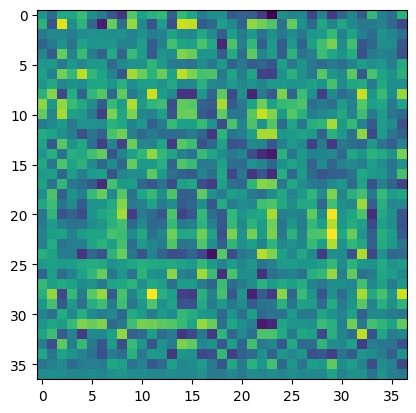

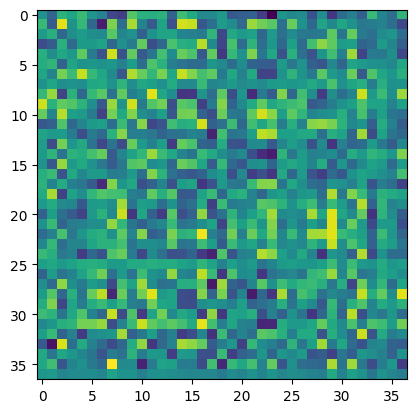

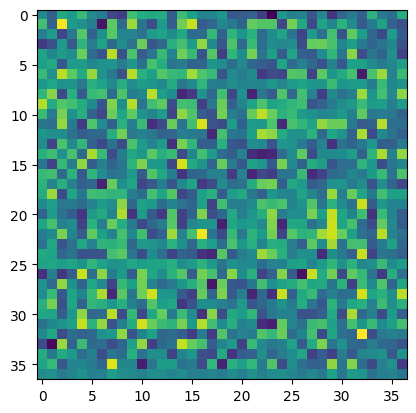

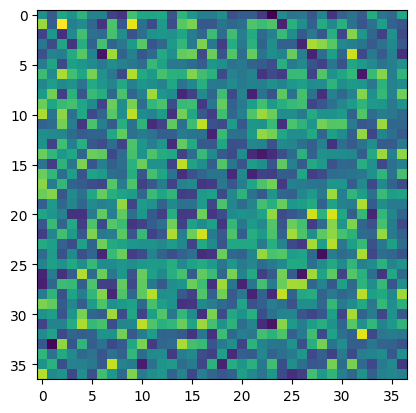

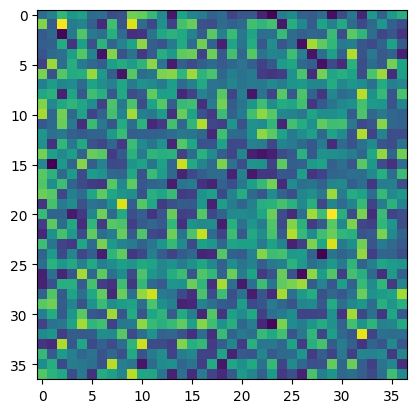

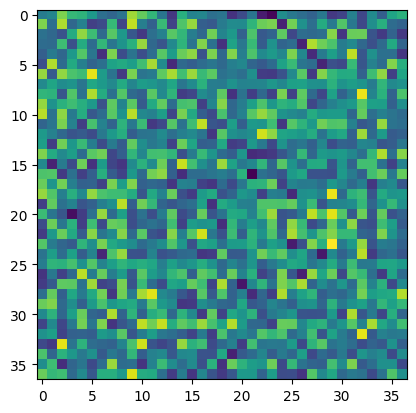

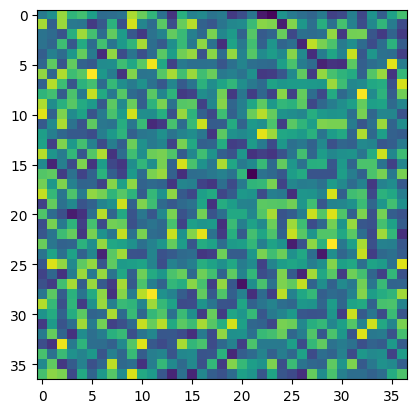

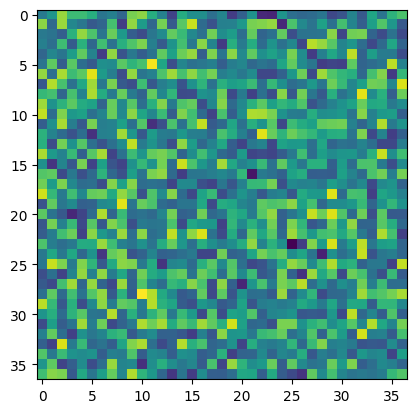

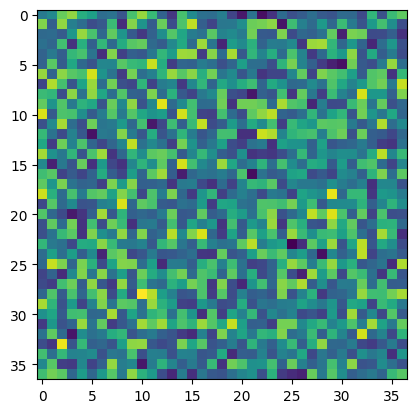

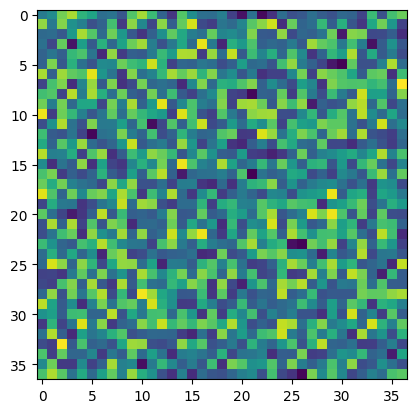

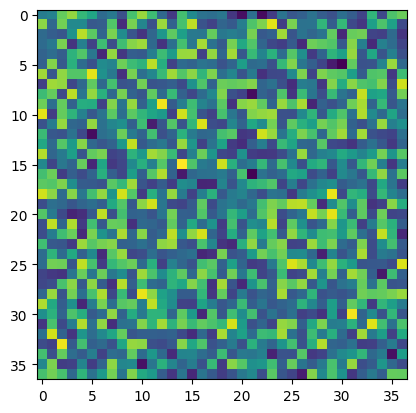

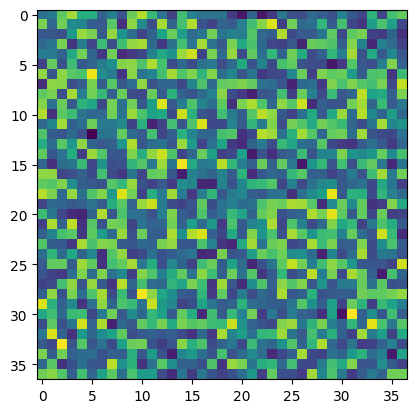

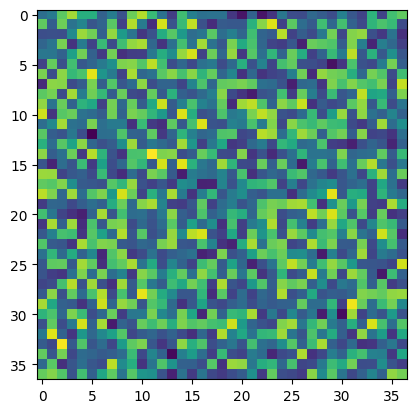

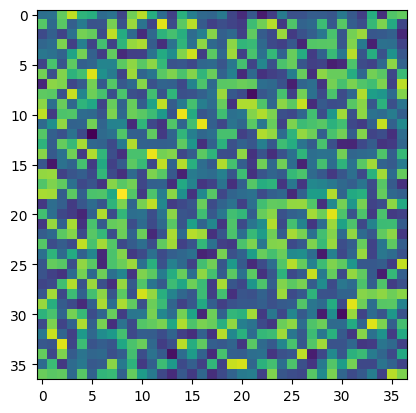

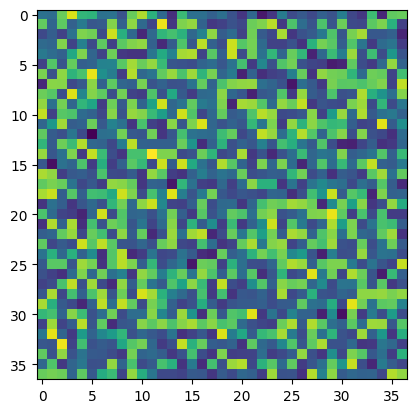

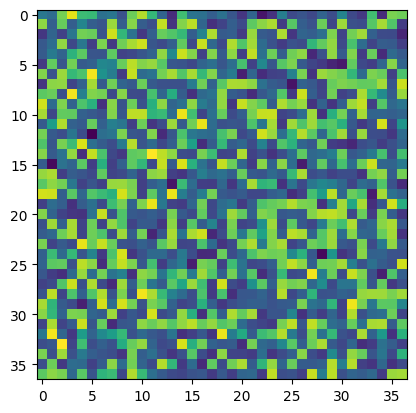

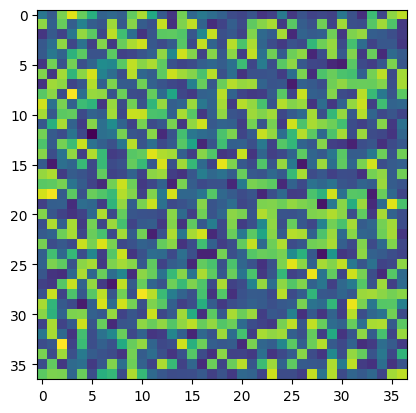

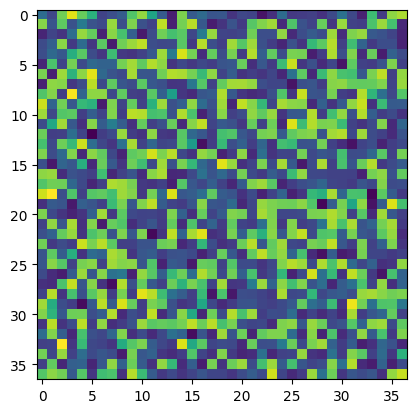

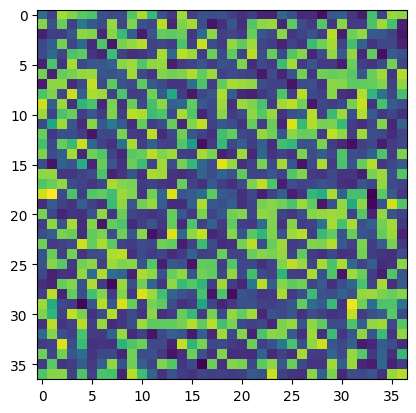

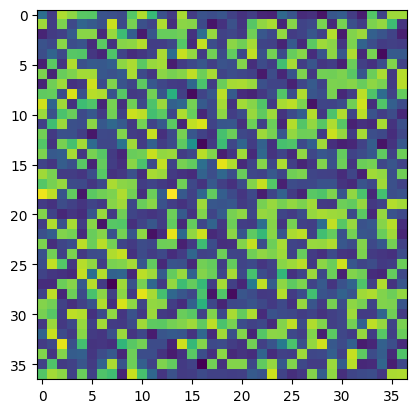

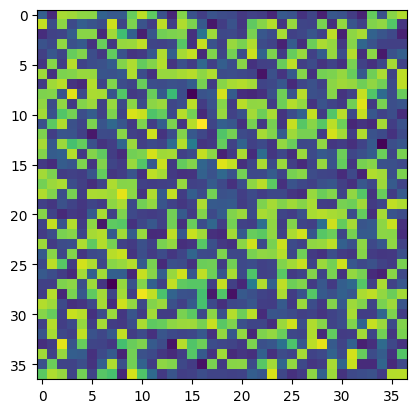

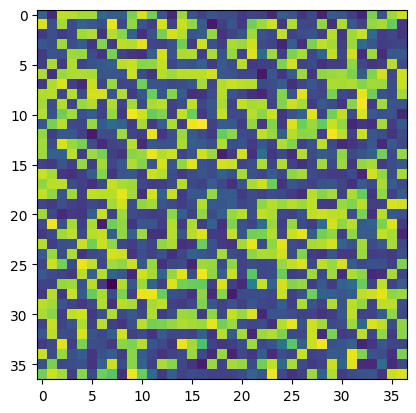

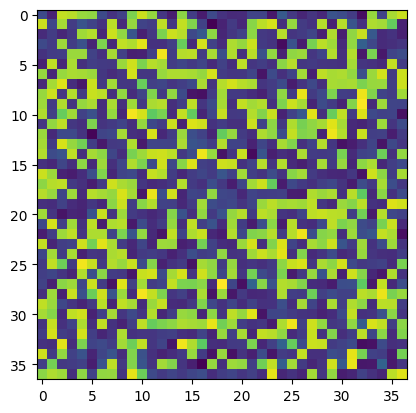

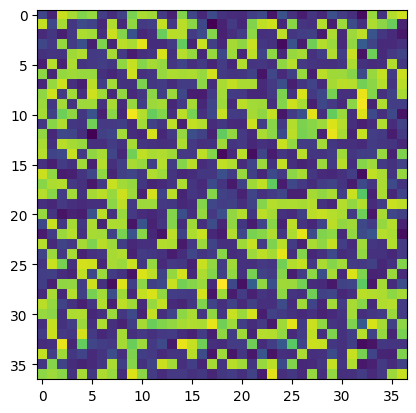

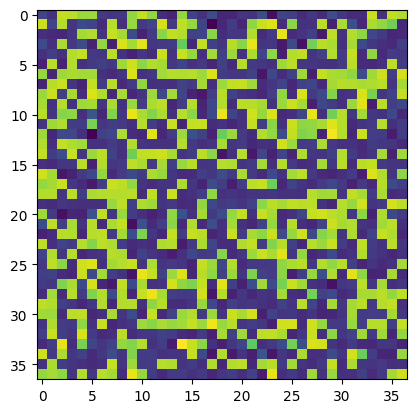

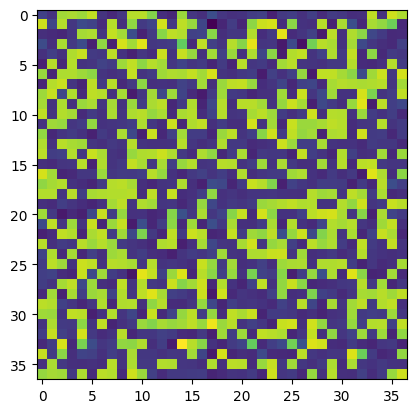

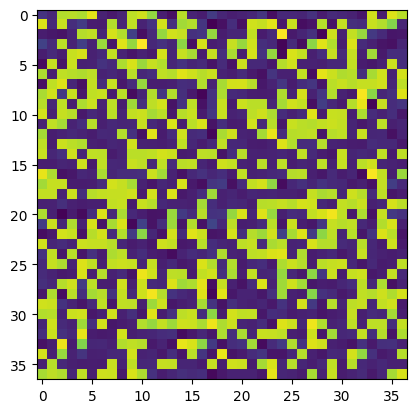

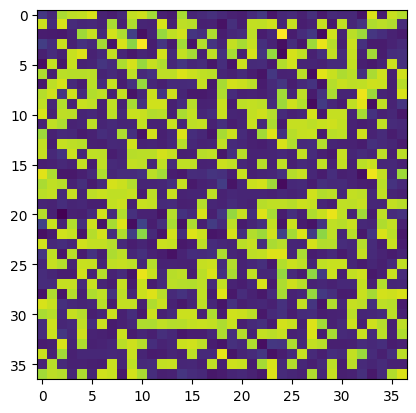

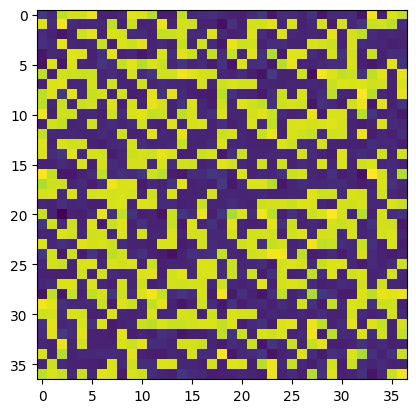

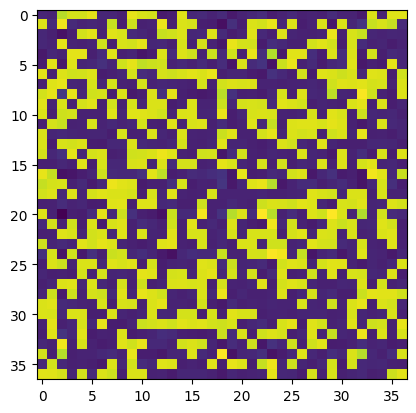

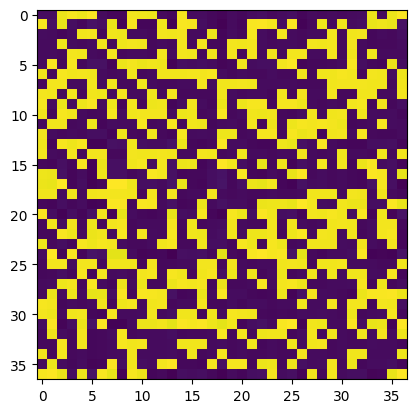

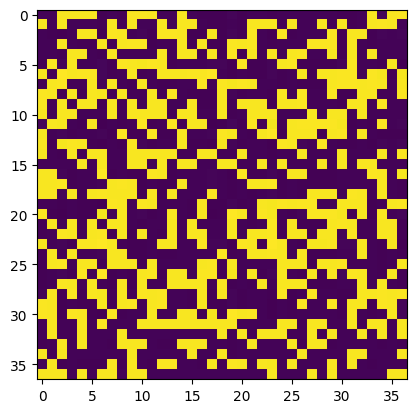

In [15]:


for i in range(density.r):
    plt.imshow(density.p1s[:,:i+1] @ density.p2s[:,:i+1].t())
    plt.show()

In [62]:
w_c[:N1].size()

torch.Size([23])

In [178]:
plt.imshow(U.conj().angle())

In [94]:
d

37